<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/MNIST_Latent_Space_Flow_Matching_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download/Install Packages

In [1]:
!pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [2]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 8.2 MB/s eta 0:00:00


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from umap import UMAP
from umap.plot import points
import umap

from tensorflow.keras.datasets import mnist

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

# Config

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
image_size = 28
sample_size = 20000

In [6]:
def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  x_test = x_test.astype('float32')
  x_test /= 255
  x_test = x_test * 2 - 1
  return x_train, y_train, x_test, y_test

In [7]:
X_train, y_train, X_test, y_test = get_mnist_data()
flat_X_train = X_train[:sample_size].reshape(len(X_train[:sample_size]), -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
pca_umap_pipeline = Pipeline([
    ("PCA", PCA(n_components=40)),
    ("UMAP", UMAP(n_components=2, random_state=42))
])
pca_umap_pipeline = pca_umap_pipeline.fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Preprocessing

In [9]:
reduced_mnist = pca_umap_pipeline.fit_transform(flat_X_train)
reduced_mnist_df = pd.DataFrame(reduced_mnist)

reduced_mnist_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1
0,6.500267,6.396587
1,13.368768,2.101022
2,3.767967,13.605200
3,-1.881207,-2.746832
4,1.144917,11.958029


# Visualize Samples from Latent Space

In [10]:
grid_size = 20

corners = np.array([
    [-3, -3],
    [-3, 15],
    [17, 1],
    [4.5, 15],
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, grid_size)
    for x in np.linspace(0, 1, grid_size)
])

inv_transformed_points = pca_umap_pipeline.inverse_transform(test_pts)

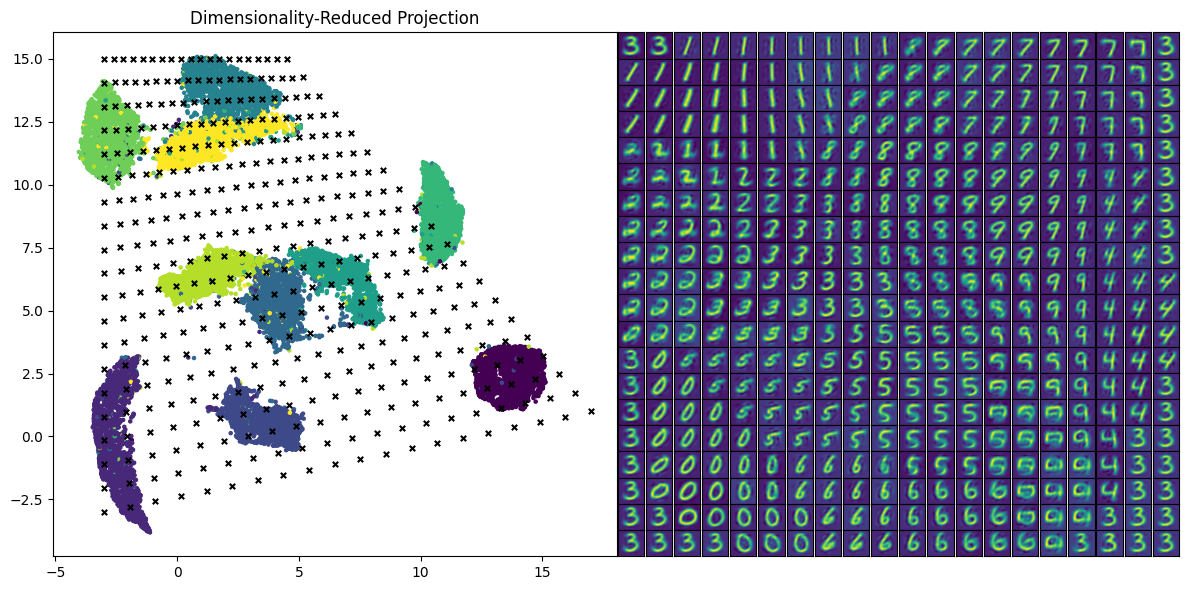

In [11]:
# Set up the grid
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(grid_size, 2 * grid_size, fig)
# Set all padding in GridSpec to 0
gs.update(wspace=0, hspace=0)
scatter_ax = fig.add_subplot(gs[:, :grid_size])
digit_axes = np.zeros((grid_size, grid_size), dtype=object)

for i in range(grid_size):
    for j in range(grid_size):
        digit_axes[i, j] = fig.add_subplot(gs[i, grid_size + j])

# Plot projection onto the scatter axis (use scatter_ax, not plt)
scatter_ax.scatter(
    x=reduced_mnist_df[0],
    y=reduced_mnist_df[1],
    s=5,
    c=y_train[:sample_size]
)
scatter_ax.set_title(f"Dimensionality-Reduced Projection")

# Plot test points
scatter_ax.scatter(
    test_pts[:, 0],
    test_pts[:, 1],
    marker='x',
    c='k',
    s=15
)

# Plot each of the generated digit images
for i in range(grid_size):
    for j in range(grid_size):
        ax = digit_axes[i, j]
        ax.imshow(inv_transformed_points[i * grid_size + j].reshape(28, 28))
        ax.set(xticks=[], yticks=[])

# Show everything at once
plt.tight_layout()
plt.show()

# Visualize a point within the latent space

## Config

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import output
from IPython.display import display, clear_output
import ipywidgets as widgets

In [13]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [15]:
def get_interactive_scatter_widget():
  # Create subplots with 1 row, 2 columns
  fig = go.FigureWidget(make_subplots(
      rows=1,
      cols=2,
      subplot_titles=("Latent Space", "Reconstructed digit"),
      specs=[[
          {"type": "scatter"},
          {"type": "image"}
      ]],
      horizontal_spacing=0.05,
      vertical_spacing=0
  ))

  # Add scatter plot in the left panel
  scatter = go.Scatter(
      x=reduced_mnist_df[0],
      y=reduced_mnist_df[1],
      mode='markers',
      marker=dict(
          size=5,
          color=y_train[:sample_size],
          colorscale='viridis',
          showscale=True
      ),
      name="Data Points",
      hovertemplate="x: %{x:.3f}<br>y: %{y:.3f}<extra></extra>"
  )
  fig.add_trace(scatter, row=1, col=1)

  # Add empty image in the right panel (placeholder)
  empty_img = np.zeros((28, 28))
  img_trace = go.Heatmap(
      z=empty_img,
      colorscale='gray',
      showscale=False,
      hoverinfo='skip'
  )
  fig.add_trace(img_trace, row=1, col=2)

  # Update layout
  fig.update_layout(
      title="Interactive Latent Space Visualization",
      height=400,
      width=800,
      showlegend=False
  )

  # Remove axes from image subplot
  fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=2)
  fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False, row=1, col=2)

  return fig

## Helpers

In [16]:
def get_inv_trans_img(x_pt, y_pt):
  inv_img = pca_umap_pipeline.inverse_transform([[x_pt, y_pt]])[0]
  # inv = (inv - inv.min())/(inv.max() - inv.min() + 1e-8)
  return inv_img.reshape(28, 28)

In [17]:
# Function to handle click events
def update_image_on_click(trace, points, selector):
    print("updating image")

    if points.point_inds:  # Check if there are clicked points
        # Get the coordinates of the clicked point
        point_idx = points.point_inds[0]
        x_pt = points.xs[0]
        y_pt = points.ys[0]

        print(f"mouse at {x_pt:.3f}, {y_pt:.3f}")
        print(f"Getting inverse transform for [{round(x_pt, 2)}, {round(y_pt, 2)}], please wait...")

        # Get inverse transform
        inv_img = get_inv_trans_img(x_pt, y_pt)
        print("Retrieved inverse transform!")

        # Update the image
        with fig.batch_update():
            fig.data[1].z = inv_img

        fig.show()

## Get Interactive Plots

In [18]:
fig = get_interactive_scatter_widget()
# Connect the click event to the scatter plot
fig.data[0].on_click(update_image_on_click)
fig.show()

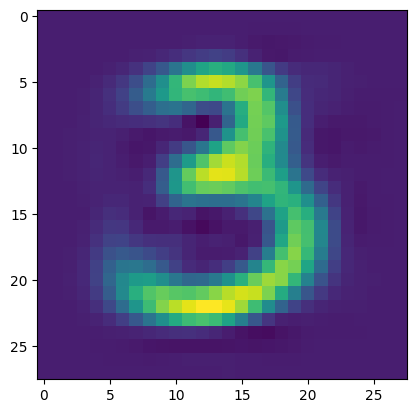

In [20]:
import random
inv_img = pca_umap_pipeline.inverse_transform([[random.random()*17 - 2, random.random()*17 - 2]]).reshape(28, 28)
plt.imshow(inv_img)